In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import parent
import networks

In [2]:
from collections import OrderedDict
import torch.nn.functional as F
from mermaidlite import compute_warped_image_multiNC, identity_map_multiN
import torch
import random
import inverseConsistentNet
import networks
import network_wrappers
import data
import numpy as np
import matplotlib.pyplot as plt

In [3]:
r_ds = torch.load("/playpen/tgreer/knees_real_train_set")
batched_ds = list(zip(r_ds[::3], r_ds[1::3], r_ds[2::3]))

In [8]:
BATCH_SIZE = 32
SCALE = 1  # 1 IS QUARTER RES, 2 IS HALF RES, 4 IS FULL RES
input_shape = [BATCH_SIZE, 1, 40 * SCALE, 96 * SCALE, 96 * SCALE]

GPUS = 4


phi = network_wrappers.FunctionFromMatrix(
    networks.StumpyConvolutionalMatrixNet(dimension=3)
)
psi = network_wrappers.FunctionFromVectorField(
    networks.tallUNet2(dimension=3)
)

net = inverseConsistentNet.InverseConsistentNet(
    network_wrappers.DoubleNet(phi, psi),
    lambda x, y: torch.mean((x - y) ** 2),
    100,
)

network_wrappers.assignIdentityMap(net, input_shape)

adjust_batch_size(net, 32)

trained_weights = torch.load("../results/affine_deformable_knee_nopretrain3/knee_aligner_resi_net6000")
net.load_state_dict(trained_weights)

<All keys matched successfully>

In [10]:
phiAffine = network_wrappers.FunctionFromMatrix(
    networks.StumpyConvolutionalMatrixNet(dimension=3)
)
psiAffine = network_wrappers.FunctionFromMatrix(
    networks.StumpyConvolutionalMatrixNet(dimension=3)
)

netAffine = inverseConsistentNet.InverseConsistentNet(
    network_wrappers.DoubleNet(phiAffine, psiAffine),
    lambda x, y: torch.mean((x - y) ** 2),
    100,
)
network_wrappers.assignIdentityMap(netAffine, input_shape)
adjust_batch_size(netAffine, 32)

In [13]:
affine_trained_weights = torch.load("../results/affine_knee_pretrain_2/knee_aligner_resi_net45900")
netAffine.load_state_dict(affine_trained_weights)

<All keys matched successfully>

In [15]:
frankenNet = inverseConsistentNet.InverseConsistentNet(
    network_wrappers.DoubleNet(netAffine.regis_net, net.regis_net),
    lambda x, y: torch.mean((x - y) ** 2),
    100
    )
network_wrappers.assignIdentityMap(frankenNet, input_shape)

In [17]:
adjust_batch_size(frankenNet, 3)
frankenNet.cuda()
frankenNet.eval()

InverseConsistentNet(
  (regis_net): DoubleNet(
    (netPsi): DoubleNet(
      (netPsi): FunctionFromVectorField(
        (net): UNet2(
          (downConvs): ModuleList(
            (0): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
            (1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
            (2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
            (3): Conv3d(64, 256, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
            (4): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          )
          (upConvs): ModuleList(
            (0): ConvTranspose3d(48, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
            (1): ConvTranspose3d(96, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
            (2): ConvTranspose3d(192, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
            (3): C

In [19]:
net = frankenNet
dices = []
for x in batched_ds:
    x = list(zip(*x))
    x = [torch.cat(r, 0).cuda().float() for r in x]
    fixed_image, fixed_cartilage = x[0], x[2]
    moving_image, moving_cartilage = x[1], x[3]
    
    net(moving_image, fixed_image)
    fat_phi = torch.nn.Upsample(size=moving_cartilage.size()[2:], mode="trilinear")(net.phi_AB(net.identityMap)[:, :3])
    sz = np.array(fat_phi.size())
    spacing = 1./(sz[2::]-1) 
    warped_moving_cartilage = compute_warped_image_multiNC(moving_cartilage.float(), fat_phi, spacing, 1)
    wmb = warped_moving_cartilage > .5
    fb = fixed_cartilage > .5
    intersection = wmb * fb
    d = 2 * torch.sum(intersection).float() / (torch.sum(wmb) + torch.sum(fb))
    print(d)
    dices.append(d)
dd = np.mean([d.item() for d in dices])
print(dd)

tensor(0.4311, device='cuda:0')
tensor(0.3478, device='cuda:0')
tensor(0.4608, device='cuda:0')
tensor(0.5045, device='cuda:0')
tensor(0.4809, device='cuda:0')
tensor(0.3287, device='cuda:0')
tensor(0.3448, device='cuda:0')
tensor(0.2800, device='cuda:0')
tensor(0.3949, device='cuda:0')
tensor(0.3371, device='cuda:0')
tensor(0.4089, device='cuda:0')
tensor(0.3271, device='cuda:0')
tensor(0.3438, device='cuda:0')
tensor(0.4696, device='cuda:0')
tensor(0.3693, device='cuda:0')
tensor(0.4677, device='cuda:0')
tensor(0.4125, device='cuda:0')
tensor(0.3791, device='cuda:0')
tensor(0.4264, device='cuda:0')
tensor(0.4314, device='cuda:0')
tensor(0.4721, device='cuda:0')
tensor(0.4698, device='cuda:0')
tensor(0.4043, device='cuda:0')
tensor(0.4387, device='cuda:0')
tensor(0.4269, device='cuda:0')
tensor(0.4263, device='cuda:0')
tensor(0.4594, device='cuda:0')
tensor(0.3262, device='cuda:0')
tensor(0.3893, device='cuda:0')
tensor(0.4717, device='cuda:0')
tensor(0.4432, device='cuda:0')
tensor(0

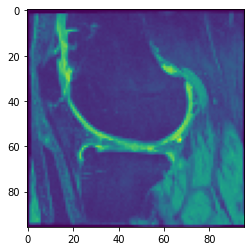

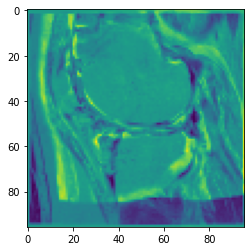

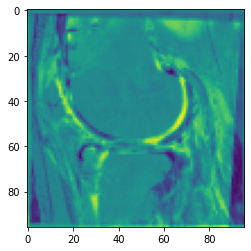

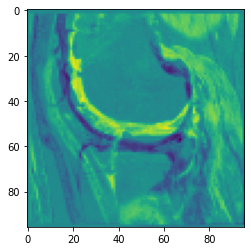

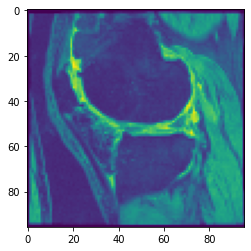

In [22]:
if not("N" in locals()):
    N = 0
N += 1
N %= 3
#plt.imshow(fixed_image[N, 0, 10].cpu() - net.warped_image_A[N, 0, 10].cpu().detach())
#plt.show()

plt.imshow(moving_image[N, 0, 10].cpu().detach())
plt.show()
plt.imshow(net.warped_image_A[N, 0, 10].cpu().detach() - fixed_image[N, 0, 10].cpu().detach())
plt.show()
plt.imshow(net.regis_net.x_comp_phi[N, 0, 10].cpu().detach() - moving_image[N, 0, 10].cpu().detach())
plt.show()
plt.imshow((fixed_image - moving_image)[N, 0, 10].cpu().detach())
plt.show()
plt.imshow(fixed_image[N, 0, 10].cpu().detach())
plt.show()

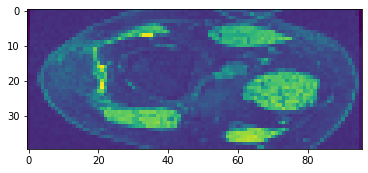

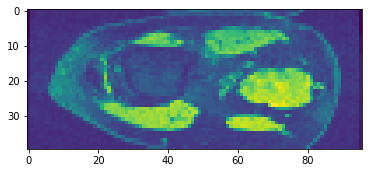

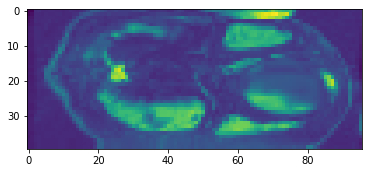

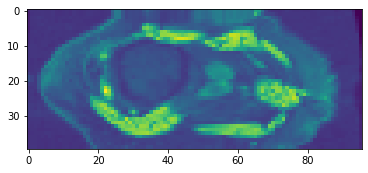

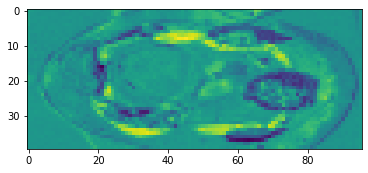

In [34]:
import matplotlib.pyplot as plt
plt.imshow(moving_image[0, 0, :, 10].cpu())
plt.show()
plt.imshow(fixed_image[0, 0, :, 10].cpu())
plt.show()
plt.imshow(net.warped_image_A[0, 0, :, 10].cpu().detach())
plt.show()
plt.imshow(net.warped_image_B[0, 0, :, 10].cpu().detach())
plt.show()

plt.imshow(net.warped_image_B[0, 0, :, 10].cpu().detach() - moving_image[0, 0, :, 10].cpu())

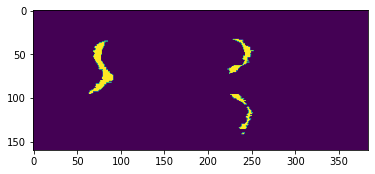

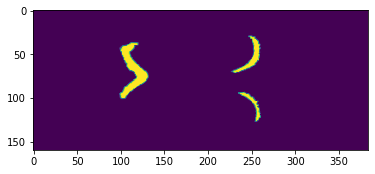

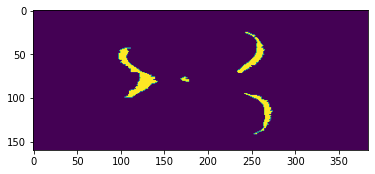

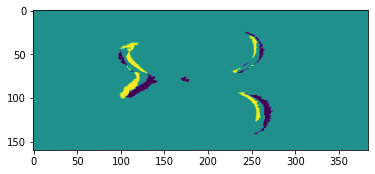

In [37]:
#N +=1
N %= 3
S = 40
plt.imshow(moving_cartilage[N, 0, :, S * 4].cpu())
plt.show() 
plt.imshow(warped_moving_cartilage[N, 0, :, S * 4].detach().cpu())
plt.show()

plt.imshow(fixed_cartilage[N, 0, :, S * 4].cpu())
plt.show()

plt.imshow((warped_moving_cartilage[N, 0, :, S * 4].detach().cpu() - fixed_cartilage[N, 0, :, S * 4].cpu()))
plt.show()

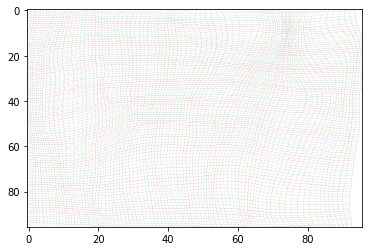

In [29]:
import visualize
visualize.show_as_grid(net.phi_AB_vectorfield[0, [1, 2], 20])

In [32]:
c = net.phi_AB.__closure__[0]
c.cell_contents.__closure__[0].cell_contents

tensor([[[ 1.0144e+00, -1.4725e-02, -2.0055e-02,  6.3593e-03],
         [ 9.5594e-04,  1.0146e+00,  5.3511e-03,  8.0860e-04],
         [ 1.5067e-02, -6.3062e-03,  1.0077e+00, -1.7288e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 9.7454e-01, -1.0601e-02, -8.8819e-03,  1.7068e-02],
         [ 4.2222e-03,  9.9989e-01,  5.0027e-03, -3.4177e-04],
         [-5.8819e-03, -3.8857e-03,  9.8886e-01,  2.7959e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 1.0425e+00,  1.1575e-02,  1.2502e-02, -2.9236e-02],
         [-5.9480e-03,  9.9934e-01, -1.0445e-02, -1.9113e-03],
         [-5.1858e-03,  1.8575e-02,  1.0388e+00, -1.6596e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       device='cuda:0', grad_fn=<UnsafeViewBackward>)

In [41]:
isinstance(net.regis_net.netPhi.net.convs[0], torch.nn.Module)

True

In [45]:
type(net.regisNet.netPhi)

ModuleAttributeError: 'InverseConsistentNet' object has no attribute 'regisNet'

In [30]:
from torch import nn
isinstance(list(net.regis_net.netPhi.netPhi.net.children())[1], nn.Linear)

True